In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.special import expit

In [15]:
def sigmoid_interpolation(y_values, x_original, x_interpolated):
    y_interpolated = np.zeros_like(x_interpolated)
    for i in range(1, len(y_values)):
        # Segment interpolation between each pair of points
        x_start, x_end = x_original[i-1], x_original[i]
        y_start, y_end = y_values[i-1], y_values[i]
        
        # Normalize to [0, 1] for the sigmoid function
        x_segment = x_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)]
        x_normalized = (x_segment - x_start) / (x_end - x_start)
        
        # Apply sigmoid for ease-in and ease-out
        sigmoid_segment = expit(12 * (x_normalized - 0.5))  # Steepness factor 12 for sharp transition
        y_segment = y_start + (y_end - y_start) * sigmoid_segment
        
        # Store the interpolated segment
        y_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)] = y_segment
    
    return y_interpolated

def linear_interpolation(y_values, x_original, x_interpolated):
    y_interpolated = np.zeros_like(x_interpolated)
    for i in range(1, len(y_values)):
        # Segment interpolation between each pair of points
        x_start, x_end = x_original[i-1], x_original[i]
        y_start, y_end = y_values[i-1], y_values[i]
        
        # Select the segment for interpolation
        x_segment = x_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)]
        
        # Linear interpolation
        y_segment = y_start + (y_end - y_start) * (x_segment - x_start) / (x_end - x_start)
        
        # Store the interpolated segment
        y_interpolated[(x_interpolated >= x_start) & (x_interpolated <= x_end)] = y_segment
    
    return y_interpolated

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_18645/1893338013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depth.loc[0:1799, "depth"] = df_depth.loc[0:1799, "depth"].replace(0.0, 1.0)


Text(0, 0.5, 'depth')

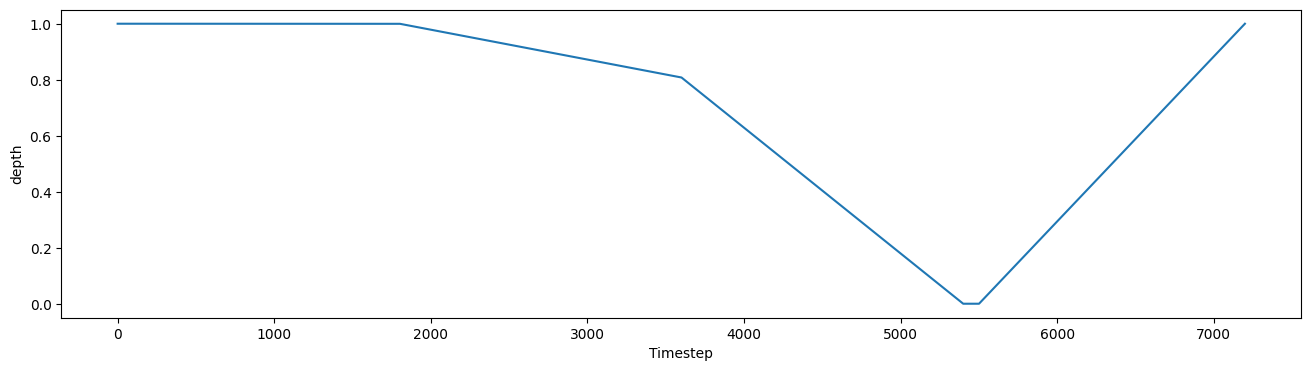

In [39]:
df = pd.read_csv("./data/12min_pass_v07.csv")
df_depth = df[["depth"]]
df_depth.loc[0:1799, "depth"] = df_depth.loc[0:1799, "depth"].replace(0.0, 1.0)
plt.figure(figsize=(16, 4))
plt.plot(df_depth.index,df_depth['depth'])
plt.xlabel('Timestep')
plt.ylabel('depth')

In [44]:
interpolated_data = []

# Iterate through each column in the DataFrame
for col in df_depth.columns:
    # Create an empty list to store the interpolated values for this column
    interpolated_column = []
    
    # Loop through each pair of consecutive points in the original DataFrame
    for i in range(len(df_depth) - 1):
        # Get the start and end points for this pair
        start = df_depth.iloc[i][col]
        end = df_depth.iloc[i + 1][col]
        
        # Generate three points: the original start, two interpolated points, and the original end
        interp_values = np.linspace(start, end, 4)  # 4 evenly spaced points

        # Add all 3 points (without excluding any)
        interpolated_column.extend(interp_values[:-1])
    
    # Add the final value from the last point in the original DataFrame
    interpolated_column.extend(np.linspace(df.iloc[-2][col], df.iloc[-1][col], 3)[-2:])

    # Append the interpolated column data
    interpolated_data.append(interpolated_column)

# Convert the interpolated data into a DataFrame
df_interpolated = pd.DataFrame(np.array(interpolated_data).T, columns=df_depth.columns)



In [45]:
df_interpolated.shape

(21599, 1)

Text(0, 0.5, 'depth')

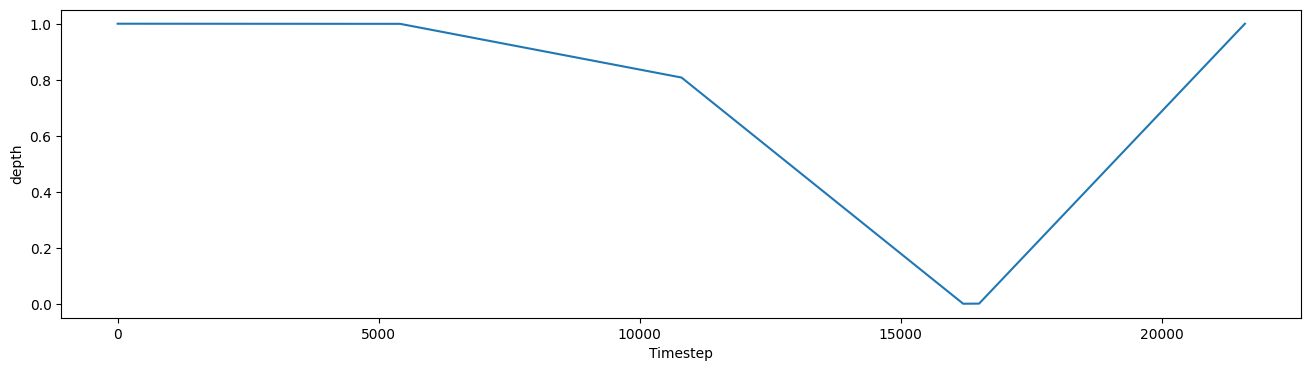

In [46]:
plt.figure(figsize=(16, 4))
plt.plot(df_interpolated.index,df_interpolated['depth'])
plt.xlabel('Timestep')
plt.ylabel('depth')

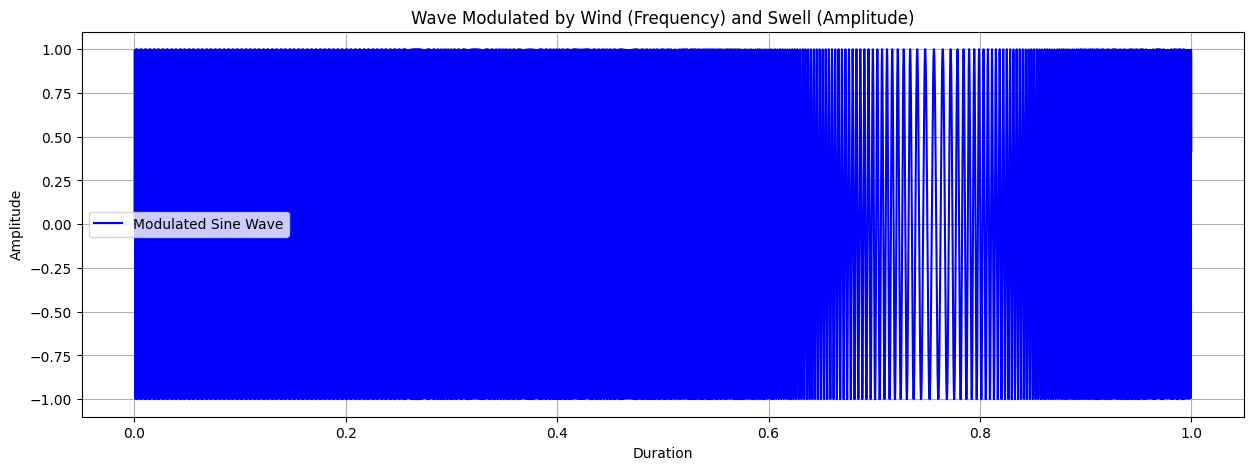

In [47]:
# Mapping function for frequency
def map_to_frequency(value, min_freq=0.1667*720, max_freq=1.1667*720): #70 bpm to 10 bpm
    return min_freq + (max_freq - min_freq) * value

# Apply mapping to frequency and use swell as amplitude
frequencies = df_interpolated['depth'].apply(map_to_frequency).to_numpy()

x_interpolated = np.linspace(0, 1, 21599)

# Generate the sine wave with varying frequency
time_step = 1 / len(x_interpolated)  # Time step for each sample
sine_wave = np.zeros_like(x_interpolated)
phase = 0  # Initial phase

for i in range(1, len(x_interpolated)):
    # Increment the phase based on the current frequency
    phase += 2 * np.pi * frequencies[i] * time_step
    sine_wave[i] = np.sin(phase)

# Plotting the sine wave
plt.figure(figsize=(15, 5))
plt.plot(x_interpolated, sine_wave, color='b', label='Modulated Sine Wave')
plt.xlabel('Duration')
plt.ylabel('Amplitude')
plt.title('Wave Modulated by Wind (Frequency) and Swell (Amplitude)')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
# Convert sine_wave to DataFrame
df_sine_wave = pd.DataFrame({'time': x_interpolated, 'sine_wave': sine_wave})
df_sine_wave.to_csv("./data/sine_04.csv",index= False)

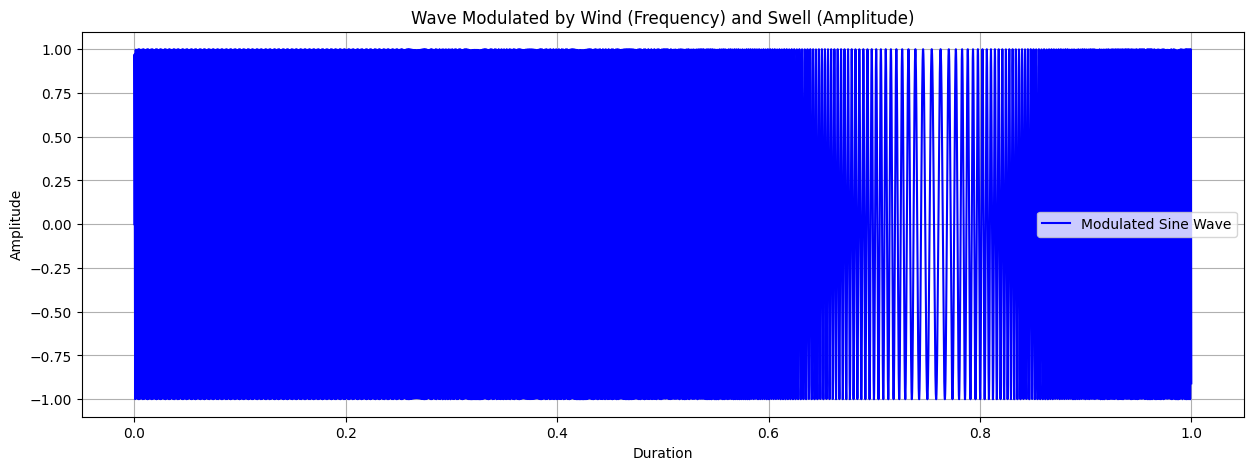

In [49]:
# Mapping function for frequency
def map_to_frequency(value, min_freq=0.1667*720, max_freq=1.1667*720):
    return min_freq + (max_freq - min_freq) * value

# Apply mapping to frequency and use swell as amplitude
frequencies = df_interpolated['depth'].apply(map_to_frequency).to_numpy()

x_interpolated = np.linspace(0, 1, 21599)

# Generate the sine wave with varying frequency
time_step = 1 / len(x_interpolated)  # Time step for each sample
sine_wave = np.zeros_like(x_interpolated)
phase = 0  # Initial phase

for i in range(1, len(x_interpolated)):
    # Increment the phase based on the current frequency
    phase += 2 * np.pi * frequencies[i] * time_step
    sine_wave[i] = np.cos(phase)

# Plotting the sine wave
plt.figure(figsize=(15, 5))
plt.plot(x_interpolated, sine_wave, color='b', label='Modulated Sine Wave')
plt.xlabel('Duration')
plt.ylabel('Amplitude')
plt.title('Wave Modulated by Wind (Frequency) and Swell (Amplitude)')
plt.grid(True)
plt.legend()
plt.show()

In [50]:
df_cosine_wave = pd.DataFrame({'time': x_interpolated, 'cosine_wave': sine_wave})
df_cosine_wave.to_csv("./data/cosine_04.csv",index= False)

In [51]:
df_cosine_wave.head()

,time,cosine_wave
0,0.000000,0.000000
1,0.000046,0.970291
2,0.000093,0.882930
3,0.000139,0.743108
4,0.000185,0.559132
